# NOAA SCRIPPS BUOY DATA

This Jupyter Notebook uses Python, Pandas, and Matplotlib to analyze a text file with various ocean data from an NOAA buoy located at Scripps. It contains data from a period of 45 days (February 28th, 2022 through April 14th, 2022), with samples every 30 minutes. 

Its given columns are: 
 - **YY** - year  
 - **MM** - month
 - **DD** - day 
 - **hh** - hour
 - **mm** - minute
 - **WVHT** - wave height   
 - **DPD** - dominant wave period (time between waves for the swell with the most energy). There are usually multiple different swells in the water at the same time, each swell has its own characteristics of size, period, and direction.
 - **APD** - average wave period (average time between waves for all the different swells in the water) 
 - **MWD** - wave direction of the dominant swell. It is measured in degrees, 270 is from due west, 180-270 is from the south, 270-360 is from the north.
 - **WTMP** - water temperature
 
 The text file is in the Github repository. Data source: https://www.ndbc.noaa.gov/station_page.php?station=46254

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import calendar
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
fh = open('noaa_buoy_data.txt', 'r')
raw = fh.read()

The text file has inconsistent spacing between characters, with one or more spaces. Here I use regular expressions to replace any multiple space gaps with only one space, so that the Pandas read_csv method can properly read everything using a single space as the delimeter. 

In [3]:
regex = ' +'
raw_formatted = re.sub(regex, ' ', raw)
fh.close()

Creating a new text file with the newly formatted string.

In [4]:
fh = open('noaa_buoy_data_formatted.txt', 'w')
fh.write(raw_formatted)
fh.close()

Creating the Pandas DataFrame with the newly formatted text file.

In [5]:
df = pd.read_csv('noaa_buoy_data_formatted.txt', sep=' ')
print(df.head())

    #YY  MM  DD  hh  mm  WDIR WSPD  GST WVHT  DPD  APD   MWD PRES  ATMP  WTMP  \
0   #yr  mo  dy  hr  mn  degT  m/s  m/s    m  sec  sec  degT  hPa  degC  degC   
1  2022  04  14  03  26    MM   MM   MM  1.1    8  5.6   287   MM    MM  17.3   
2  2022  04  14  02  56    MM   MM   MM  1.2    8  5.7   288   MM    MM  17.3   
3  2022  04  14  02  26    MM   MM   MM  1.2    8  5.9   285   MM    MM  17.4   
4  2022  04  14  01  56    MM   MM   MM  1.2    8  5.8   289   MM    MM  17.4   

   DEWP  VIS PTDY TIDE  
0  degC  nmi  hPa   ft  
1    MM   MM   MM   MM  
2    MM   MM   MM   MM  
3    MM   MM   MM   MM  
4    MM   MM   MM   MM  


<br>

Some of the columns don't have data, so we can remove them.

In [6]:
df = df.drop(columns = ['WDIR', 'WSPD', 'GST', 'PRES', 'ATMP', 'DEWP', 'VIS', 'PTDY', 'TIDE'])

The first row of data are actually units for the columns, so we can rename the columns to include the units, then remove that row.

In [7]:
df = df.rename(columns={'#YY':'year', 'MM':'month', 'DD':'day', 'hh':'hour', 'mm':'minute', 
                        'WVHT':'WVHT(m)', 'DPD':'DPD(sec)', 'APD':'APD(sec)', 'MWD':'MWD(deg)', 'WTMP':'WTMP(degC)'})
df = df.drop(index = 0)
print(df.head())

   year month day hour minute WVHT(m) DPD(sec) APD(sec) MWD(deg) WTMP(degC)
1  2022    04  14   03     26     1.1        8      5.6      287       17.3
2  2022    04  14   02     56     1.2        8      5.7      288       17.3
3  2022    04  14   02     26     1.2        8      5.9      285       17.4
4  2022    04  14   01     56     1.2        8      5.8      289       17.4
5  2022    04  14   01     26     1.2        7      6.0      281       17.5


<br>

The Water Temp column is a string type, so we want to convert it to float. It is also in degrees C, so we create a new column of Water Temp in degrees F and delete the old column.

In [8]:
df['WTMP(degC)'] = pd.to_numeric(df['WTMP(degC)']) 
df['WTMP(degF)'] = (df['WTMP(degC)'] * 1.8) + 32 
df = df.drop(columns = ['WTMP(degC)'])

The Wave Height column is a string type, so we also convert this to float. It is in meters, so we create a new column of Wave Height in feet and delete the old column.

In [9]:
df['WVHT(m)'] = pd.to_numeric(df['WVHT(m)'])
df['WVHT(ft)'] = df['WVHT(m)'] * 3.28
df = df.drop(columns = ['WVHT(m)'])

We also want to convert the Dominant Wave Period, Average Wave Period, and Mean Wave Direction from string to numeric.

In [10]:
df['DPD(sec)'] = pd.to_numeric(df['DPD(sec)'])
df['APD(sec)'] = pd.to_numeric(df['APD(sec)'])
df['MWD(deg)'] = pd.to_numeric(df['MWD(deg)'])

We can use the year, month, day, hour, and minute columns to create a new column of type DateTime and set it as the index.

In [11]:
df['DateTime'] = pd.to_datetime(df[['year','month','day','hour','minute']])
df = df.set_index('DateTime', drop=True)
print(df.head())

                     year month day hour minute  DPD(sec)  APD(sec)  MWD(deg)  \
DateTime                                                                        
2022-04-14 03:26:00  2022    04  14   03     26         8       5.6       287   
2022-04-14 02:56:00  2022    04  14   02     56         8       5.7       288   
2022-04-14 02:26:00  2022    04  14   02     26         8       5.9       285   
2022-04-14 01:56:00  2022    04  14   01     56         8       5.8       289   
2022-04-14 01:26:00  2022    04  14   01     26         7       6.0       281   

                     WTMP(degF)  WVHT(ft)  
DateTime                                   
2022-04-14 03:26:00       63.14     3.608  
2022-04-14 02:56:00       63.14     3.936  
2022-04-14 02:26:00       63.32     3.936  
2022-04-14 01:56:00       63.32     3.936  
2022-04-14 01:26:00       63.50     3.936  


<br>

Now we can see the overview of our DataFrame.

In [12]:
print(df.describe())
print(df.info())

          DPD(sec)     APD(sec)     MWD(deg)   WTMP(degF)     WVHT(ft)
count  2147.000000  2147.000000  2147.000000  2147.000000  2147.000000
mean     10.172799     6.423335   286.985095    61.197979     3.327512
std       2.808993     1.040942     6.400923     1.668715     1.382948
min       4.000000     3.700000   237.000000    55.220000     1.312000
25%       8.000000     5.700000   284.000000    59.720000     2.296000
50%      10.000000     6.400000   288.000000    61.160000     2.952000
75%      13.000000     7.000000   291.000000    62.240000     3.936000
max      18.000000    10.100000   312.000000    70.160000     8.856000
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2147 entries, 2022-04-14 03:26:00 to 2022-02-28 00:26:00
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        2147 non-null   object 
 1   month       2147 non-null   object 
 2   day         2147 non-null   object 
 3   hour    

<br>

First, we can use Matplotlib to plot a histogram of the Wave Height measurements to see what the wave height usually is. Each bin is one foot. The most frequent Wave Height measurement is between 2-3 feet, and there are no measurements below 1 foot or over 9 feet.

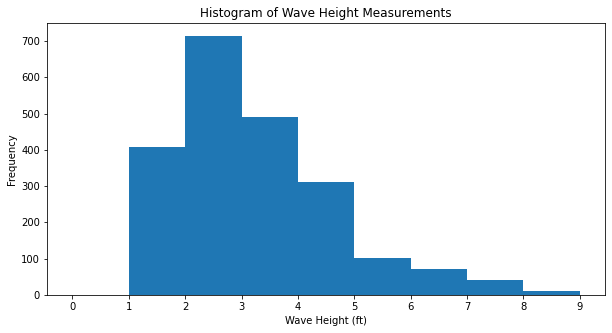

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(df['WVHT(ft)'], bins=list(range(10)))
plt.xticks(list(range(10)))
plt.title('Histogram of Wave Height Measurements')
plt.xlabel('Wave Height (ft)')
plt.ylabel('Frequency')
plt.show()

We can use a boolean array to find when the Wave Height was the biggest, above 8 feet. It looks like this was from a single swell, taking place from March 5th to 6th.

In [14]:
print(df[df['WVHT(ft)'] > 8].loc[:, 'DPD(sec)':'WVHT(ft)'])
# using .loc only selects certain columns to show for clarity

                     DPD(sec)  APD(sec)  MWD(deg)  WTMP(degF)  WVHT(ft)
DateTime                                                               
2022-03-06 07:56:00         8       6.1       291       59.18     8.200
2022-03-06 06:56:00         7       6.0       287       59.18     8.200
2022-03-06 06:26:00         8       6.0       285       59.18     8.528
2022-03-06 05:56:00         8       6.1       287       59.18     8.856
2022-03-06 05:26:00         8       6.0       285       59.18     8.200
2022-03-06 04:56:00         8       6.0       289       59.18     8.528
2022-03-06 03:56:00         8       5.9       287       59.18     8.528
2022-03-06 03:26:00         8       5.8       288       59.18     8.528
2022-03-06 02:56:00         7       5.7       285       59.36     8.200
2022-03-06 01:56:00         7       5.8       289       59.36     8.200
2022-03-05 21:56:00         8       6.2       284       59.54     8.200


<br>

We can also plot a histogram of the Wave Direction measurements to see where the dominant swell usually comes from. Each bin is 10 degrees. It looks like the majority of swell is coming from the north, above 270 degrees. This makes sense because in the winter most swell is from the north, and in the summer most swell is from the south.

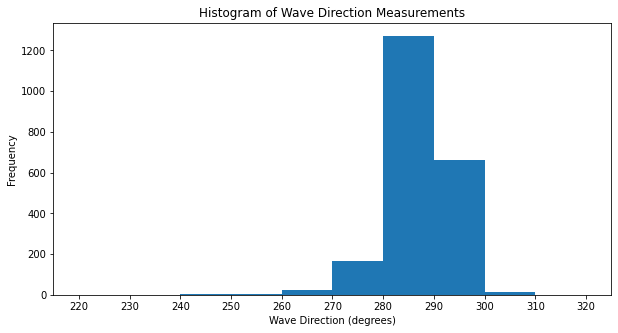

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(df['MWD(deg)'], bins=list(range(220, 330, 10)))
plt.xticks(list(range(220, 330, 10)))
plt.title('Histogram of Wave Direction Measurements')
plt.xlabel('Wave Direction (degrees)')
plt.ylabel('Frequency')
plt.show()

We can calculate the percentages of south swell and north swell.

In [16]:
south = len(df[df['MWD(deg)'] < 270]) / len(df) * 100
north = len(df[df['MWD(deg)'] > 270]) / len(df) * 100
# round to nearest tenth
south = round(south, 1)
north = round(north, 1)
print('Percentage of south swell is ' + str(south) + '%.')
print('Percentage of north swell is ' + str(north) + '%.')

Percentage of south swell is 1.4%.
Percentage of north swell is 98.3%.


<br>

Finally, here is a histogram of the Dominant Wave Period measurements.

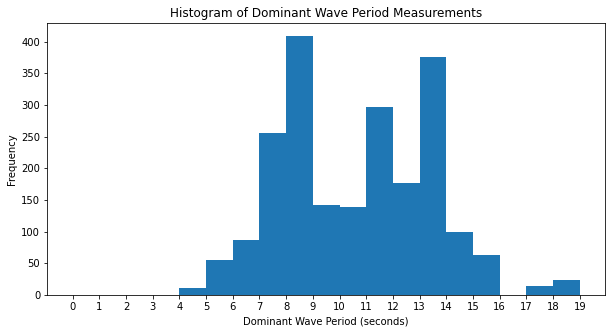

In [17]:
plt.figure(figsize=(10, 5))
plt.hist(df['DPD(sec)'], bins=list(range(20)))
plt.xticks(list(range(20)))
plt.title('Histogram of Dominant Wave Period Measurements')
plt.xlabel('Dominant Wave Period (seconds)')
plt.ylabel('Frequency')
plt.show()

<br>

We can also try a line plot to see trends over time. Here is the Wave Height

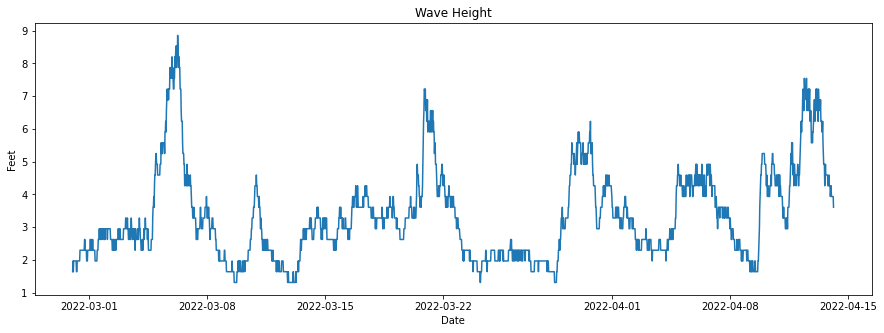

In [18]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['WVHT(ft)'])
ax.set_title('Wave Height')
ax.set_xlabel('Date')
ax.set_ylabel('Feet')
plt.show()

<br>

It looks a bit choppy, we can try finding the averages for each day, since there are 48 data points per day.

In [19]:
df_means = df.groupby(['month', 'day']).mean()
print(df_means.head())

            DPD(sec)  APD(sec)    MWD(deg)  WTMP(degF)  WVHT(ft)
month day                                                       
02    28   13.978723  6.946809  291.893617   59.639574  2.114553
03    01   13.063830  8.482979  290.319149   59.628085  2.519319
      02   12.333333  8.581250  290.729167   60.095000  2.671833
      03   13.791667  8.910417  293.770833   59.873750  2.876833
      04   12.187500  6.958333  285.229167   58.988750  3.040833


<br>

Now we can try replotting Wave Height over time with the new daily averages.

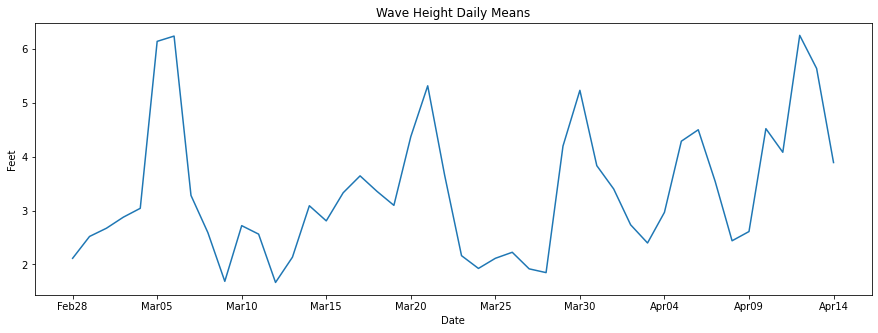

In [20]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = df_means['WVHT(ft)'].plot()
ax.set_title('Wave Height Daily Means')
ax.set_xlabel('Date')
ax.set_ylabel('Feet')

# Creating labels for the x ticks
x_tups = df_means.index.to_list()[0:46:5]
x_lists = [list(i) for i in x_tups]
for i in range(len(x_lists)):
    x_lists[i][0] = calendar.month_abbr[int(x_lists[i][0])]
x_labels = [i+j for i,j in x_lists]
    
ax.set_xticks(np.arange(0, 46, 5), x_labels)
plt.show()

<br>

Here is the plot for Water Temperature over time using the daily averages.

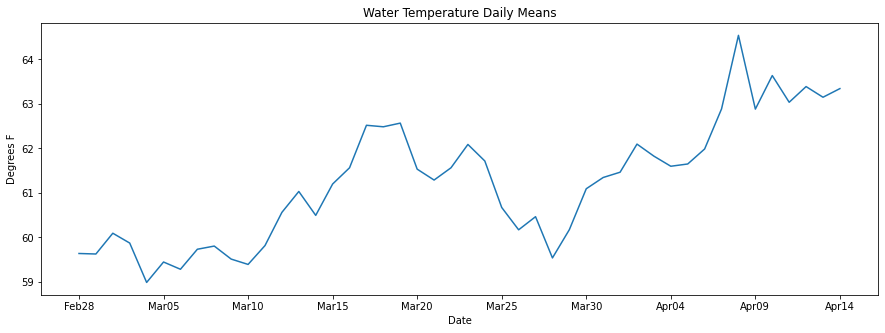

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = df_means['WTMP(degF)'].plot()
ax.set_title('Water Temperature Daily Means')
ax.set_xlabel('Date')
ax.set_ylabel('Degrees F')
ax.set_xticks(np.arange(0, 46, 5), x_labels)
plt.show()

<br>

Here are the plots for Dominant and Average Wave Period over time using the daily averages.

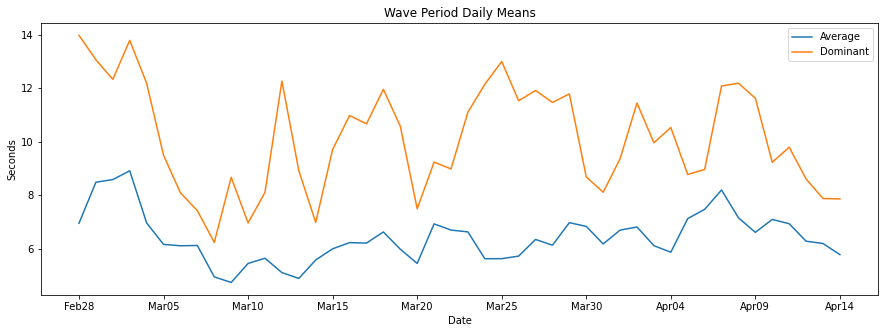

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))
ax = df_means['APD(sec)'].plot(label='Average')
ax = df_means['DPD(sec)'].plot(label='Dominant')
ax.set_title('Wave Period Daily Means')
ax.set_xlabel('Date')
ax.legend()
ax.set_ylabel('Seconds')
ax.set_xticks(np.arange(0, 46, 5), x_labels)
plt.show()

<br>

<br>

We can also plot a correlation matrix to see if any varaibles are correlated. A value of -1 is strongly negatively correlated, 1 is strongly positively correlated, and 0 is no correlation.

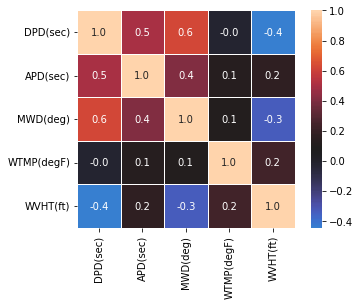

In [23]:
corr = df_means.corr()
sns.heatmap(corr, linewidths=1, annot=True, square=True, fmt='.1f', center=0.08)
plt.show()

Nothing has a very strong correlation, the strongest is Wave Direction 'MWD(deg)' and Dominant Wave Period 'DPD(sec)' with a value of 0.6. Lets see what they look like on a scatter plot together. 

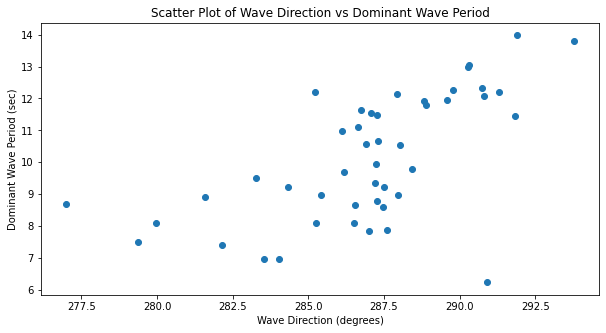

In [24]:
plt.figure(figsize=(10, 5))
plt.scatter(df_means['MWD(deg)'],df_means['DPD(sec)'])
plt.title('Scatter Plot of Wave Direction vs Dominant Wave Period')
plt.xlabel('Wave Direction (degrees)')
plt.ylabel('Dominant Wave Period (sec)')
plt.show()

Adding a linear regression line of best fit.

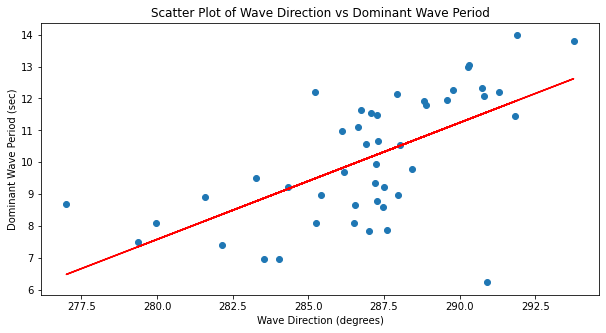

In [25]:
plt.figure(figsize=(10, 5))
plt.scatter(df_means['MWD(deg)'],df_means['DPD(sec)'])
plt.title('Scatter Plot of Wave Direction vs Dominant Wave Period')
plt.xlabel('Wave Direction (degrees)')
plt.ylabel('Dominant Wave Period (sec)')

model = LinearRegression()
x = df_means['MWD(deg)'].values.reshape(-1, 1)
y = df_means['DPD(sec)'].values.reshape(-1, 1)
model.fit(x,y)
y_line = model.predict(x)
plt.plot(df_means['MWD(deg)'], y_line, 'r')

plt.show()